

### The objective is to create a predictive model that accurately estimates the crop yield per acre for rice or wheat crops in India. The model will assist smallholder farmers in making informed decisions regarding planting, resource allocation, and adaptive farming practices to break the cycle of poverty and malnutrition.

For this project we will supervised learning techniques since we already know our target "rop yield per acre" and we will use some regressions since the target is a continuous data


### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Creating a Wrangle Function
This Function embodies data cleaning, preprocessing, and encoding
This function was modified progressively after observing the data set.
The following were achieved in this function;
- Reading the csv file as a dataframe
- Dropping columns with morethan 50% of null values 
- Changing columns that had dates to datetime types inorder to find the number od days between when a seed was planted and it was harvested.
- All other categorical features were encoded into integer data types by using the Label Encoder
- Null values were filled with the median of each column.
- Outliers were removed by removing the values that do not lie between the 0.01 to 0.85 range
- All other missing values will certainly not be from a numerical value and so they were filled with 0
- Columns with multi linear colinearity were dropped 
- and finally the function returns a clean csv file called df

In [21]:
#writing a function that reads csv file ceans it and returns a clean file
def wrangle(file):
    df = pd.read_csv(file)
    
#     Drop columns that have more 50% of nullvalues
    perc = 50
    min_null = int(((100-perc)/100)*df.shape[0] + 1)
    df.dropna(axis=1, thresh=min_null, inplace= True)
    
#   Now we are going to convert the date columns to datetime datatypes inorder to find the difference between the time a seed was planted and the time the crop was harvested in terms of days, so that we can see how the number of days between the planting and harvesting affects the yield of the crops.    
    df['RcNursEstDate'] = pd.to_datetime(df['RcNursEstDate'])
    df['Harv_date'] = pd.to_datetime(df['Harv_date'])
    
#  Finding the number of days between the day a seed was planted and harvested 
    df['NumberOfDaysforHarv'] = (df['Harv_date']-df['RcNursEstDate']).dt.days
    
# Encoding categorical features
    le = LabelEncoder()
    cat = df.loc[:, df.columns != 'ID']
    categories = cat.select_dtypes('object').columns
# categories
    for feat in categories:
#     if feat != 'ID' :
         df[feat] = le.fit_transform(df[feat].astype(str))
    
#     Filling null values with the median of the columns and dropping outliers
    numeric_columns = df.select_dtypes(include=np.number).columns
    for col in numeric_columns:
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            median = df[col].median()
            df[col].fillna(median, inplace=True)
            # Calculate the IQR and bounds           
            low, high = df[col].quantile([0.01, 0.85])
            mask_area = df[col].between(low, high)
            df = df[mask_area]
        else:
            df[col]=df[col]
            
# fillna into all missing vaues
    categorical_columns = df.select_dtypes(include='object').columns
    for column in categorical_columns:
        if column in categorical_columns:
#             median = df[column].median()
            df[column].fillna(0, inplace=True)
         
#drop columns with multicolinearity
    df.drop(columns = ['CultLand','BasalDAP','BasalUrea', 'Residue_perc', 'TransplantingIrrigationPowerSource','RcNursEstDate', 'Harv_date', 'MineralFertAppMethod.1', 'OrgFertilizers', 'MineralFertAppMethod', 'Threshing_method'], inplace =True)
    

    return df
df = wrangle('Train.csv')
df.head(30)
 

,ID,District,Block,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,SeedingSowingTransplanting,SeedlingsPerPit,...,1tdUrea,1appDaysUrea,Harv_method,Harv_hand_rent,Threshing_date,Residue_length,Stubble_use,Acre,Yield,NumberOfDaysforHarv
5,ID_W5MM9H353RL9,3,1,5,15,31,6,2,5,1.0,...,6.0,30.0,0,600.0,29,30,1,0.136364,205,131.0
9,ID_EDA8RK1CP60K,2,6,10,29,43,5,3,15,3.0,...,5.0,20.0,0,80.0,39,22,1,0.156250,300,124.0
23,ID_XR4T47FT6ZYJ,3,5,3,42,34,5,3,9,2.0,...,5.0,35.0,0,150.0,19,30,1,0.090909,250,111.0
33,ID_NT3N95UN82Z0,3,0,5,18,42,5,3,33,1.0,...,7.0,28.0,0,200.0,14,22,1,0.090909,180,96.0
35,ID_IC8XYYV22B5N,1,4,12,15,28,5,3,27,3.0,...,4.0,25.0,0,200.0,67,28,1,0.136364,300,117.0
40,ID_QV8OS19KF7PM,1,4,15,15,54,4,3,27,4.0,...,6.0,25.0,0,200.0,79,26,1,0.136364,300,131.0
65,ID_5IA7BLLDO4B1,3,5,5,15,19,4,3,31,1.0,...,10.0,25.0,0,200.0,37,30,1,0.227273,400,101.0
77,ID_ZD2B3CE5S5DV,3,5,5,34,27,3,3,29,2.0,...,7.0,28.0,0,350.0,14,30,1,0.136364,300,101.0
91,ID_GXWZDA7AC7HF,0,8,18,33,34,4,3,26,2.0,...,3.0,23.0,0,200.0,43,25,1,0.074074,160,122.0
94,ID_P44LR2LK3S6T,1,3,5,15,54,4,3,31,4.0,...,7.0,28.0,0,300.0,81,28,1,0.136364,240,135.0


In [3]:
variable_des = pd.read_csv('VariableDescription.csv')
variable_des

,Variable,Description
0,District,Name of the district
1,Block,Name of the block
2,CultLand,Area of total cultivated land
3,CropCultLand,Area of land under cultivation
4,LandPreparationMethod,Method for land preparation
5,CropTillageDate,Date of tillage of the largest plot
6,CropTillageDepth,Depth of the tillage
7,CropEstMethod,Method of transplantation
8,RcNursEstDate,Date of nursery establishment
9,SeedingSowingTransplanting,Crop establishment method - sowing/transplanting


### checking for outliers using the describe function, zcsore function and visualisation 

In [4]:
df.describe()

,District,Block,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,SeedingSowingTransplanting,SeedlingsPerPit,NursDetFactor,...,1tdUrea,1appDaysUrea,Harv_method,Harv_hand_rent,Threshing_date,Residue_length,Stubble_use,Acre,Yield,NumberOfDaysforHarv
count,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,...,577.000000,577.000000,577.0,577.000000,577.000000,577.000000,577.0,577.000000,577.000000,577.000000
mean,2.093588,4.641248,11.022530,26.339688,36.568458,4.467938,2.831889,24.388215,2.013865,40.715771,...,6.072790,27.334489,0.0,272.642981,44.597920,27.589255,1.0,0.128351,227.481802,125.143847
std,1.123414,2.406133,6.966526,11.271078,14.984456,0.944333,0.550715,10.573243,0.797009,36.527895,...,2.461136,6.689861,0.0,152.674618,25.279298,2.696980,0.0,0.044298,114.027729,13.249807
min,0.000000,0.000000,3.000000,1.000000,6.000000,2.000000,0.000000,0.000000,1.000000,0.000000,...,2.000000,4.000000,0.0,50.000000,9.000000,20.000000,1.0,0.045455,4.000000,90.000000
25%,1.000000,4.000000,5.000000,15.000000,27.000000,4.000000,3.000000,17.000000,2.000000,10.000000,...,4.000000,25.000000,0.0,150.000000,23.000000,25.000000,1.0,0.090909,158.000000,118.000000
50%,3.000000,5.000000,10.000000,27.000000,38.000000,4.000000,3.000000,22.000000,2.000000,25.000000,...,6.000000,27.000000,0.0,250.000000,41.000000,28.000000,1.0,0.136364,240.000000,126.000000
75%,3.000000,6.000000,15.000000,39.000000,49.000000,5.000000,3.000000,32.000000,2.000000,56.000000,...,8.000000,30.000000,0.0,400.000000,55.000000,30.000000,1.0,0.156250,320.000000,132.000000
max,3.000000,8.000000,30.000000,42.000000,72.000000,6.000000,3.000000,60.000000,4.000000,125.000000,...,12.000000,40.000000,0.0,600.000000,153.000000,30.000000,1.0,0.227273,400.000000,153.000000


In [5]:
# Iterate through each column in the dataset
from scipy.stats import zscore
def outliers(path):
#     train=pd.read_csv(path)
    for column in path.columns:
        # Check if the column contains numerical data
        if np.issubdtype(path[column].dtype, np.number):
            # Calculate the Z-scores of the column
            z_scores = zscore(path[column])

            # Identify the outliers based on a threshold
            outliers = path[abs(z_scores) > 3]  # Adjust the threshold as required

            # Print column name and outlier count
            return print(f"Column '{column}' has {len(outliers)} outliers.\n")


### Verifying if there are outliers

In [6]:
outliers(df)

Column 'District' has 0 outliers.



C:\Users\vtebo\AppData\Local\Temp\ipykernel_48296\2612950340.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


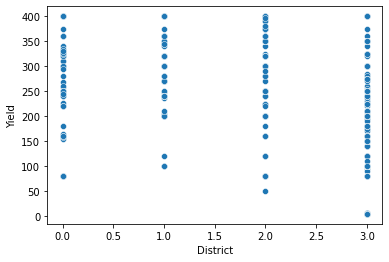

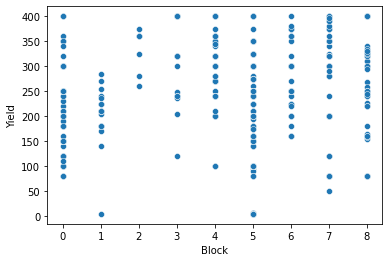

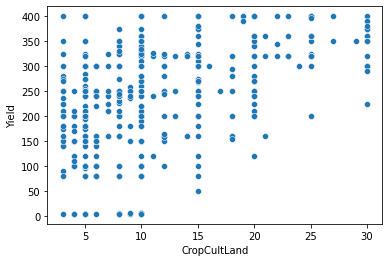

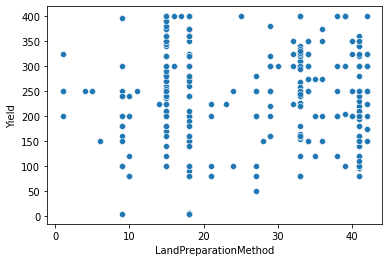

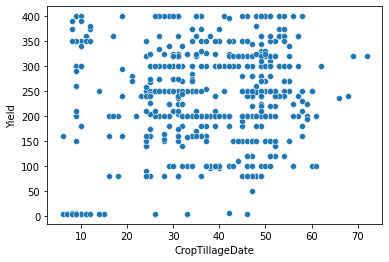

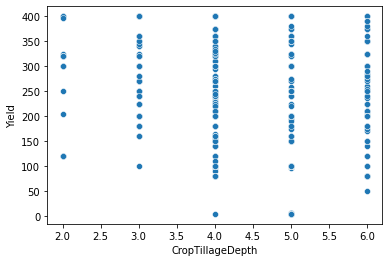

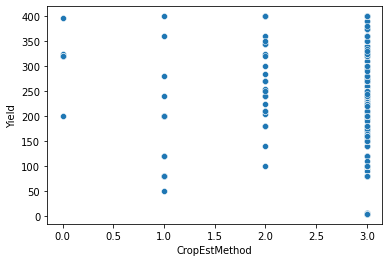

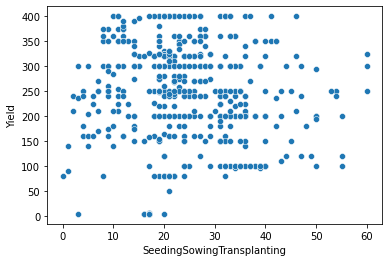

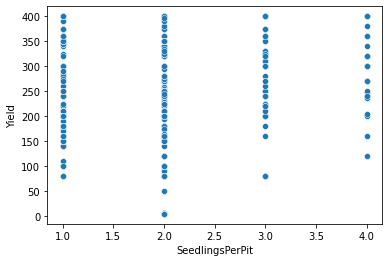

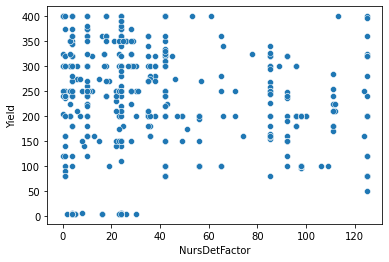

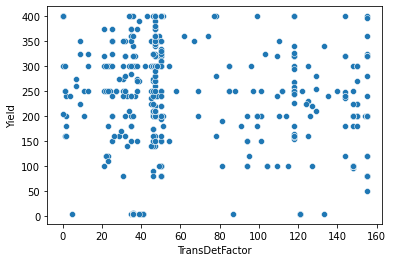

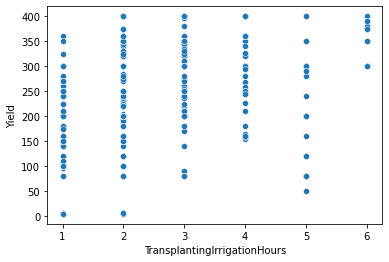

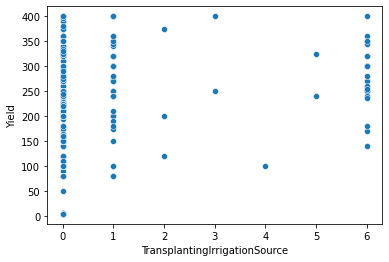

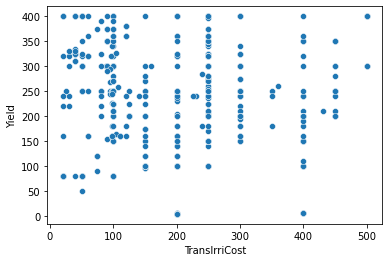

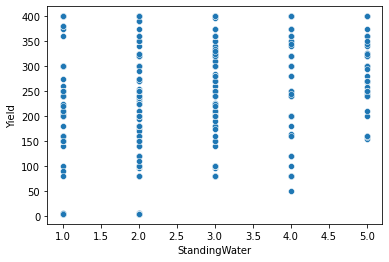

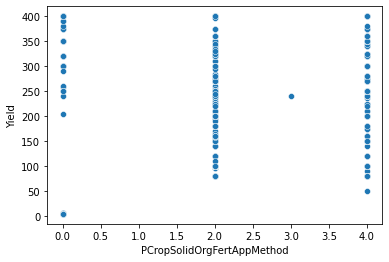

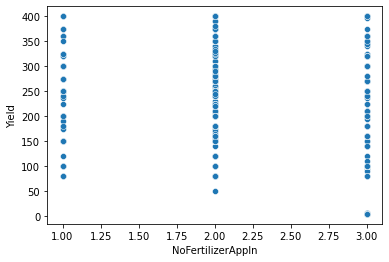

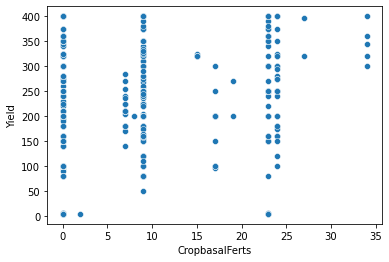

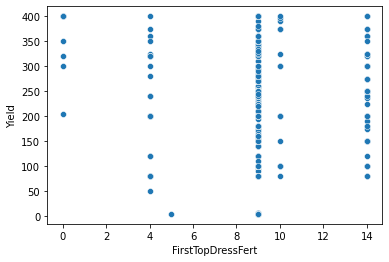

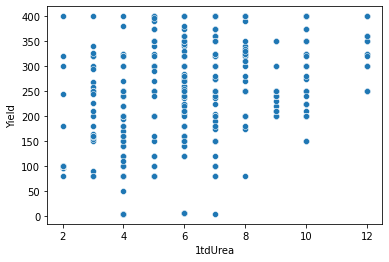

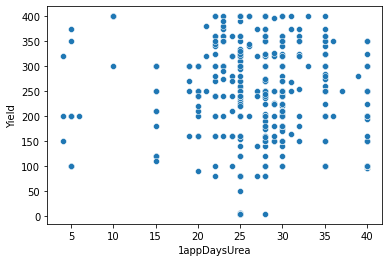

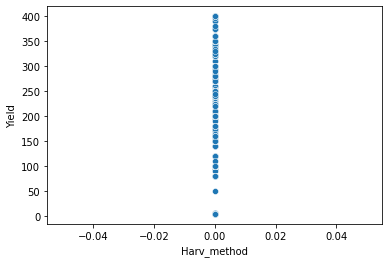

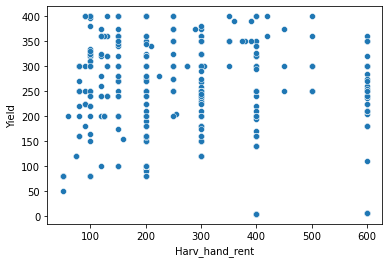

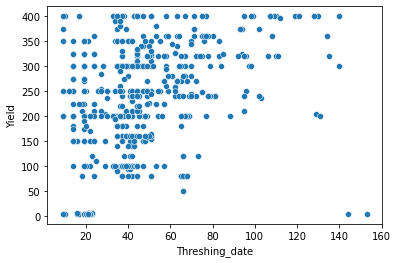

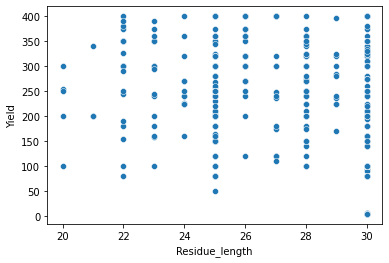

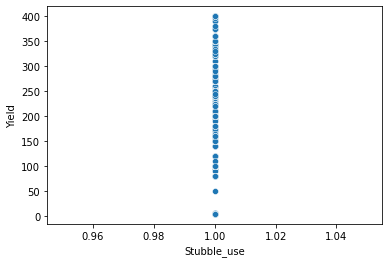

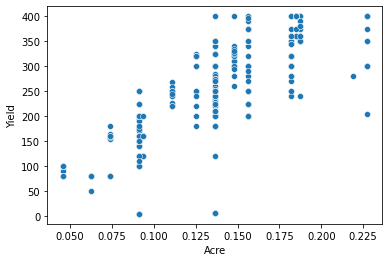

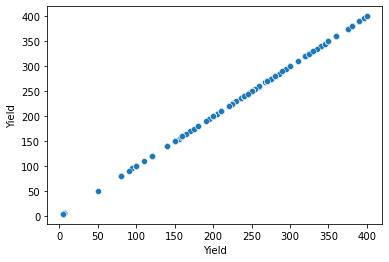

<Figure size 432x288 with 0 Axes>

In [7]:
numeric_data = list(df._get_numeric_data())
for i in range(len(numeric_data)-1):   
    sns.scatterplot(x=numeric_data[i],y='Yield', data=df, palette='winter')
    plt.figure()




In [8]:
# categorical_data = df.drop(columns='ID').select_dtypes(include='object').columns
# for i in categorical_data:    
#     sns.barplot(x= i,y='Yield', data=df, palette='winter')
#     plt.figure(figsize=(12,10))

In [9]:
corr = df.corr()
corr

,District,Block,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,SeedingSowingTransplanting,SeedlingsPerPit,NursDetFactor,...,1tdUrea,1appDaysUrea,Harv_method,Harv_hand_rent,Threshing_date,Residue_length,Stubble_use,Acre,Yield,NumberOfDaysforHarv
District,1.000000,-0.490455,-0.417533,0.085236,-0.277705,0.320312,0.039505,0.096617,-0.460991,-0.063911,...,-0.033236,0.230990,NaN,0.522324,-0.485166,0.195499,NaN,-0.393140,-0.449125,-0.280246
Block,-0.490455,1.000000,0.285513,0.015960,-0.236829,0.031222,-0.151718,-0.362270,0.145636,0.120813,...,-0.141289,0.048021,NaN,-0.321167,0.141878,0.042799,NaN,-0.035130,0.094490,0.365989
CropCultLand,-0.417533,0.285513,1.000000,-0.215320,0.064672,-0.122998,-0.199476,-0.079737,0.037465,0.037937,...,0.160194,-0.190517,NaN,-0.237259,0.373134,-0.455420,NaN,0.518574,0.499784,0.256098
LandPreparationMethod,0.085236,0.015960,-0.215320,1.000000,0.169895,-0.101083,0.148784,0.351965,-0.008449,0.114933,...,0.083223,0.340224,NaN,-0.000543,-0.156804,0.259950,NaN,-0.151934,0.051051,-0.274672
CropTillageDate,-0.277705,-0.236829,0.064672,0.169895,1.000000,-0.252434,-0.082861,0.427301,0.257515,0.164252,...,0.149661,0.075914,NaN,-0.364246,0.288175,-0.097272,NaN,0.193995,0.366180,-0.192106
CropTillageDepth,0.320312,0.031222,-0.122998,-0.101083,-0.252434,1.000000,-0.032081,-0.255743,-0.260064,0.172871,...,-0.112537,0.061747,NaN,0.166854,-0.369114,-0.063463,NaN,-0.239683,-0.267109,-0.014547
CropEstMethod,0.039505,-0.151718,-0.199476,0.148784,-0.082861,-0.032081,1.000000,0.092028,0.064650,-0.505526,...,0.028257,0.004451,NaN,0.227882,-0.287197,0.176686,NaN,-0.018921,-0.011564,-0.221520
SeedingSowingTransplanting,0.096617,-0.362270,-0.079737,0.351965,0.427301,-0.255743,0.092028,1.000000,0.066934,0.131491,...,-0.054728,0.209365,NaN,-0.027508,0.104420,0.044505,NaN,-0.032848,0.040102,-0.412773
SeedlingsPerPit,-0.460991,0.145636,0.037465,-0.008449,0.257515,-0.260064,0.064650,0.066934,1.000000,-0.139884,...,0.014531,-0.103438,NaN,-0.324744,0.385709,0.042230,NaN,0.247128,0.172465,0.206956
NursDetFactor,-0.063911,0.120813,0.037937,0.114933,0.164252,0.172871,-0.505526,0.131491,-0.139884,1.000000,...,-0.250028,0.251166,NaN,-0.083289,0.097041,-0.104862,NaN,-0.268593,-0.091528,-0.014723


### Checking For Multicolinearity

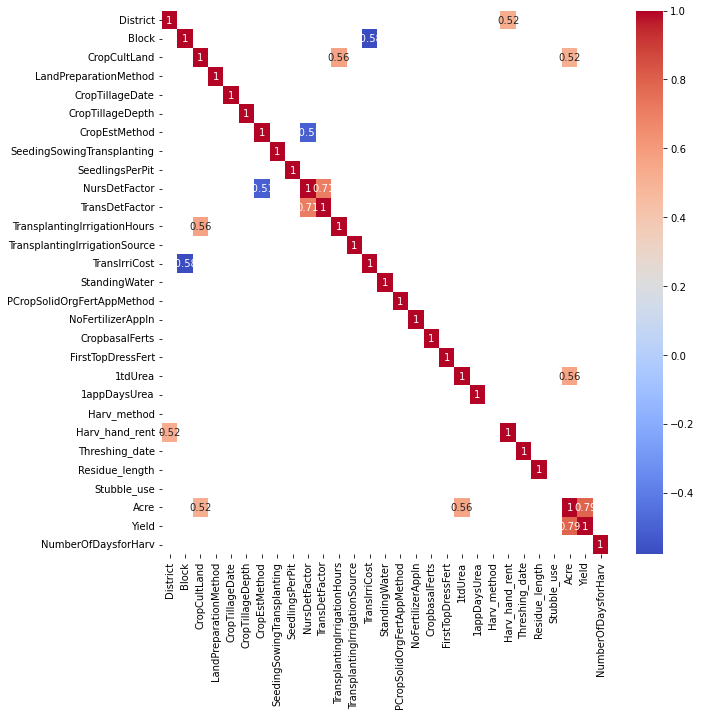

In [10]:
plt.figure(figsize=(10,10))
correlation_matrix = corr.abs()>0.5
sns.heatmap(corr[correlation_matrix], annot=True, cmap='coolwarm')
plt.show()

In [11]:
corr[correlation_matrix]

,District,Block,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,SeedingSowingTransplanting,SeedlingsPerPit,NursDetFactor,...,1tdUrea,1appDaysUrea,Harv_method,Harv_hand_rent,Threshing_date,Residue_length,Stubble_use,Acre,Yield,NumberOfDaysforHarv
District,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.522324,NaN,NaN,NaN,NaN,NaN,NaN
Block,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CropCultLand,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.518574,NaN,NaN
LandPreparationMethod,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CropTillageDate,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CropTillageDepth,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CropEstMethod,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,-0.505526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeedingSowingTransplanting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeedlingsPerPit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NursDetFactor,NaN,NaN,NaN,NaN,NaN,NaN,-0.505526,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Training the model

Using the Random Forest Tree Rgressor

In [12]:
# split the data set
X = df.drop(columns=['Yield', "ID"])
X =X.select_dtypes(include=np.number)
y = df['Yield']

X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size= 0.25, random_state= 1234)

# Instantiate model
model = RandomForestRegressor(random_state = 1234)

# Fit model
model.fit(X_train.fillna(0), y_train)

# Make predictions
preds = model.predict(X_test)

# Measure model performance
mean_squared_error(y_test, preds, squared=False)


36.44713018360554

In [13]:
mean_absolute_error(y_test, preds)


25.348620689655174

Using the GradientBoosting Regressor

In [14]:
# Instantiate model
Gb_model = GradientBoostingRegressor(random_state=42)

# Fit model
Gb_model.fit(X_train, y_train)

# Make predictions
preds = Gb_model.predict(X_test)

# Measure model performance
rmse = mean_squared_error(y_test, preds, squared=False)
mae1 = mean_absolute_error(y_test, preds)

In [15]:
rmse

37.72822916197888

In [16]:
mae1

26.815661145062265

### Predicting the values for our test dataset

In [17]:
test = wrangle('Test.csv')

In [18]:
# Make predictions on the Zindi test set
test_df = test[X.columns]
preds = model.predict(test_df.fillna(0))

# Create submisiion file to be uploaded to Zindi for scoring
sub = pd.DataFrame({'ID': test.ID, 'Yield': preds})
sub.to_csv('newSubmission1.csv', index = False)

sub.head()

,ID,Yield
1,ID_SO3VW2X4QO93,353.20
3,ID_QUISMWEZR2H4,275.51
10,ID_WI17R25TC2VU,327.89
13,ID_SCAOUCCTJ75Z,4.00
24,ID_2WH3AXUWRS2A,241.67
